# Landmarks Basics
In Menpo, we recognise the importance of annotating data. Annotations are most commonly defined as a set of coordinates on an image or a mesh that define points of interest. For example, an image may be annotated in order to provide a set of landmarks that define the major features of the face (the contour of the eyes or mouth). 

Menpo tightly couples core data types, `Image` and `PointCloud`/`PointGraph`/`TriMesh`, with landmarks. We also reuse our types here, as all landmarks are, at their core, a ``PointCloud``. This means landmarks themselves can be transformed and visualised just like any other ``PointCloud``. If you are unsure about the features of the ``PointCloud`` class, we suggest you check out the notebooks in the `Shape` package!

In the following we present:

1. `LandmarkManager`
2. `LandmarkGroup`
3. Automatically Labelling Landmarks
4. Removing Labels
5. Re-assigning landmarks
6. Widgets

Lets begin with the `io` package and demonstrate how easy it is to load images in that are landmarked!

Found 6 images


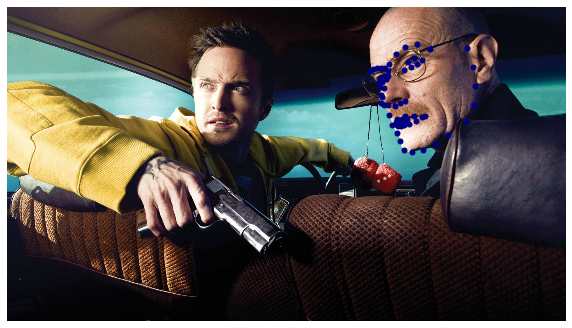

In [1]:
%matplotlib inline
import numpy as np
import os
import menpo.io as mio

images = list(mio.import_images(str(mio.data_dir_path()) + '/*'))
print('Found {} images'.format(len(images)))

# Grab the first image
img = images[0]

img.view_landmarks();

In this case, images have been automatically loaded with some landmark information attached. We can confirm that by accessing the property *.landmarks* on the images.

In [2]:
print('Is img landmarked?')
print(' - {}'.format(img.landmarks.has_landmarks))

print('How many landmark groups does it have?')
print(' - {}'.format(img.landmarks.n_groups))
    
print('What labels do these groups have?')
for g in img.landmarks.group_labels:
    print(' - {}'.format(g))

Is img landmarked?
 - True
How many landmark groups does it have?
 - 1
What labels do these groups have?
 - PTS


## 1. LandmarkManager

Every `Landmarkable` object contains a `LandmarkManager`. The `LandmarkManager` is responsible for maintaining multiple sets of landmarks per object. For example, after running a deformable model alignment the image is returned with both the initial shape *and* the final shape after fitting.

The `LandmarkManager` acts like a smart dictionary for storing landmarks. So Landmarks are stored inside of the manager and accessible by string keys that define a ``group_label`` for the landmark group.

Let's see what it looks like for an image to have two sets of landmarks by simply duplicating the Breaking Bad landmarks.

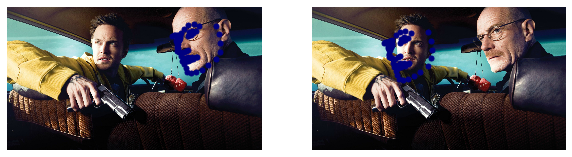

In [3]:
from menpo.transform import Translation
import matplotlib.pyplot as plt

# Grab the landmarks - this syntax will be explained shortly!
landmarks = img.landmarks['PTS'].lms
# Store a new landmark group called 'translated_landmarks'
img.landmarks['translated_landmarks'] = Translation([50, -700]).apply(landmarks)

plt.subplot(121)
img.view_landmarks(group='PTS');
plt.subplot(122)
img.view_landmarks(group='translated_landmarks');

The landmarks can also be plotted on the same figure

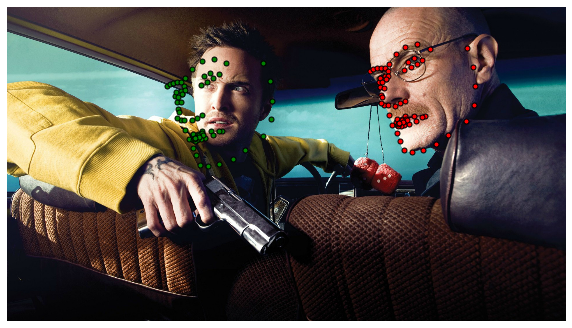

In [4]:
viewer = img.view_landmarks(group='PTS', marker_face_colour='r', marker_edge_colour='k');
img.view_landmarks(group='translated_landmarks', figure_id=viewer.figure_id, marker_face_colour='g', marker_edge_colour='k');

The image above clearly shows two seperate sets of landmarks, and the legend shows their relative colours on the right of the image. You may have noticed some interesting syntax for grabbing the landmarks from the manager, this is explained in the `LandmarkGroup` explanation!

As a sanity check, let's check that there are now two group labels on our image!

In [5]:
print('What labels do these groups have?')
for g in img.landmarks.group_labels:
    print(' - {}'.format(g))

What labels do these groups have?
 - translated_landmarks
 - PTS


## 2. LandmarkGroup

You may have noticed the ``lms`` syntax from the ``LandmarkManager`` and be wondering why we didn't just store plain ``PointCloud`` objects on the manager? Well, landmarks are more intelligent than just being plain ``PointCloud`` objects, though they do, of course, contain a ``PointCloud``.

A ``LandmarkManager`` contains a number of ``LandmarkGroup``s. These are container objects that allow us to provide semantic labels to the different coordinates within a set of landmarks. These means that each ``LandmarkGroup`` contains a single ``PointCloud``, and that ``PointCloud`` can be labelled such that each point has a different semantic meaning.

By default, if no semantic labels are provided, there is a single semantic label provided which we call 'all'. However, this might not be particularly useful! Luckily, reassigning labels to a given ``LandmarkGroup`` is very simple!

For example, given the lets take a square and label the corners!

In [6]:
from menpo.image import Image
from menpo.shape import PointCloud

square_image = Image.init_blank([100, 100])
square_image.landmarks['square'] = PointCloud([[20, 20], [20, 80], [80, 80], [80, 20]])

Let's see the default 'all' label:

In [7]:
print('Semantic labels are:')
for l in square_image.landmarks['square'].labels:
    print(' - {}'.format(l))

Semantic labels are:
 - all


Now, let's label each corner:

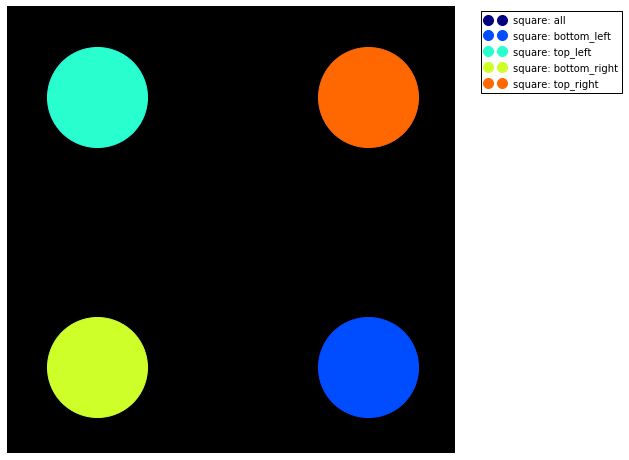

In [8]:
square_image.landmarks['square']['bottom_left'] = [2]
square_image.landmarks['square']['top_left'] = [0]
square_image.landmarks['square']['bottom_right'] = [3]
square_image.landmarks['square']['top_right'] = [1]

square_image.view_landmarks(group='square', marker_size=100, render_legend=True);

In [9]:
print('The semantic labels now are:')
for l in square_image.landmarks['square'].labels:
    print(' - {}'.format(l))

The semantic labels now are:
 - all
 - bottom_left
 - top_left
 - bottom_right
 - top_right


There are a couple of things to note here:

  - You access semantic labels in a similar way to accessing the group label on the ``LandmarkManager``, as a dictionary.
  - The new semantic labels are defined as lists of indexes into the ``PointCloud`` object. Therefore, each set of semantic labels can have many indexes.
  - The ``LandmarkGroup`` can contain as many sets of semantic labels as needed. Notice that 'all' is still present in the legend, which contains all of the points!
  - The semantic labels are prefixed with the group label
  
Since we provide a list of indices, we could define a new set of semantic labels for the points on the left and right seperately!

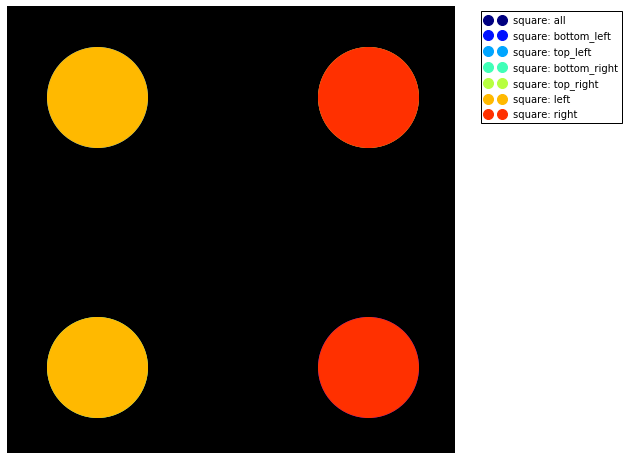

In [10]:
square_image.landmarks['square']['left'] = [0, 3]
square_image.landmarks['square']['right'] = [1, 2]

square_image.view_landmarks(group='square', marker_size=100, render_legend=True);

The problem is that it is very difficult to see what is going on, since all of the semantic labels are getting rendered on top of each other! In order to get around this, ``LandmarkGroup`` makes it easy to create a new ``LandmarkGroup`` with (or without) a given set of labels.

Landmark group has the following labels: 
  - left
  - right


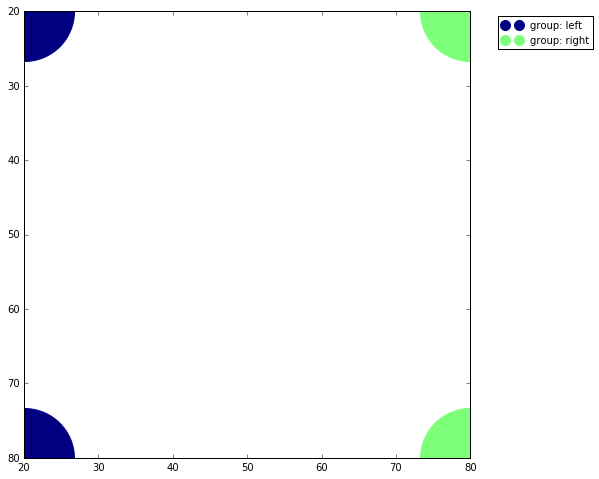

In [11]:
left_right_landmark_group = square_image.landmarks['square'].with_labels(['left', 'right'])

print('Landmark group has the following labels: ')
for g in left_right_landmark_group.labels:
    print('  - ' + g)
    
left_right_landmark_group.view(marker_size=100);

Notice that viewing a single landmark group does **not** view the underlying object as well. You must use ``view_landmarks`` to view the underlying object behind the landmarks!

Also, keep in mind that this newly created group is not assigned to the image. If we view the original again, we still see all the labels!

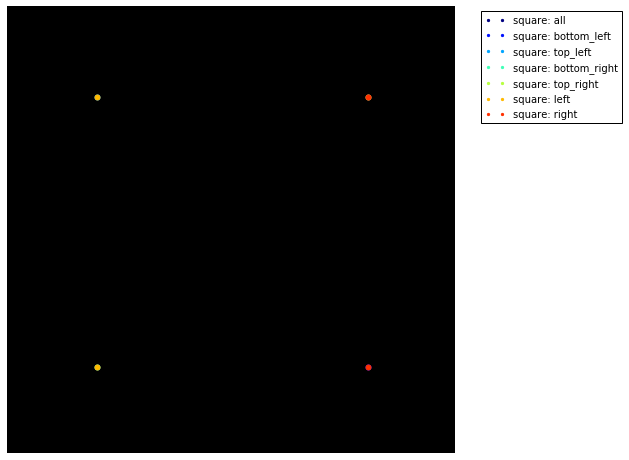

In [12]:
square_image.view_landmarks(render_legend=True);

As we described before, we can easily set a 'mask' on our underlying PointCloud that defines a semantic labelling. This has nice behaviour because it allows us to single out indices in to our PointCloud that have particular semantic meanings to us. What if we want to access those masked PointClouds though?

In [13]:
lmark_group = square_image.landmarks['square']

for semantic_label in lmark_group:
    print('Label is: {}'.format(semantic_label))
    print('Underlying PointCloud is: {}'.format(lmark_group[semantic_label]))

Label is: all
Underlying PointCloud is: PointCloud: n_points: 4, n_dims: 2
Label is: bottom_left
Underlying PointCloud is: PointCloud: n_points: 1, n_dims: 2
Label is: top_left
Underlying PointCloud is: PointCloud: n_points: 1, n_dims: 2
Label is: bottom_right
Underlying PointCloud is: PointCloud: n_points: 1, n_dims: 2
Label is: top_right
Underlying PointCloud is: PointCloud: n_points: 1, n_dims: 2
Label is: left
Underlying PointCloud is: PointCloud: n_points: 2, n_dims: 2
Label is: right
Underlying PointCloud is: PointCloud: n_points: 2, n_dims: 2


Notice the different number of points returned for each PointCloud, becase each PointCloud is a *subset* of the original PointCloud!

## 3. Automatically Labelling Landmarks

A semantic meaning can be added to a group of existing landmarks by labelling them with a predefined labelling function. This will effectively create a new landmark group with the appropiate semantic labels. For example, let's label the Breaking Bad image with the semantic annotations [from the IBUG team](http://ibug.doc.ic.ac.uk/resources/facial-point-annotations/).

In [14]:
from menpo.landmark import labeller, face_ibug_68_to_face_ibug_68

# Label some landmarks
labeller(img, 'PTS', face_ibug_68_to_face_ibug_68)

print('How many landmark groups does it have have?')
print(' - {}'.format(img.landmarks.n_groups))
    
print('What labels do these groups have?')
for g in img.landmarks:
    print(' - {}'.format(g))

print('ibug_face_68 semantic labels are?')
for l in img.landmarks['face_ibug_68']:
    print(' - {}'.format(l))

How many landmark groups does it have have?
 - 3
What labels do these groups have?
 - translated_landmarks
 - face_ibug_68
 - PTS
ibug_face_68 semantic labels are?
 - jaw
 - left_eyebrow
 - right_eyebrow
 - nose
 - left_eye
 - right_eye
 - mouth


Note that you can iterate over labels **and** landmark groups just as you would a Python dictionary.

We can now view the entire group, containing all semantic labels that seperate particular areas such as the eyes, nose, mouth etc

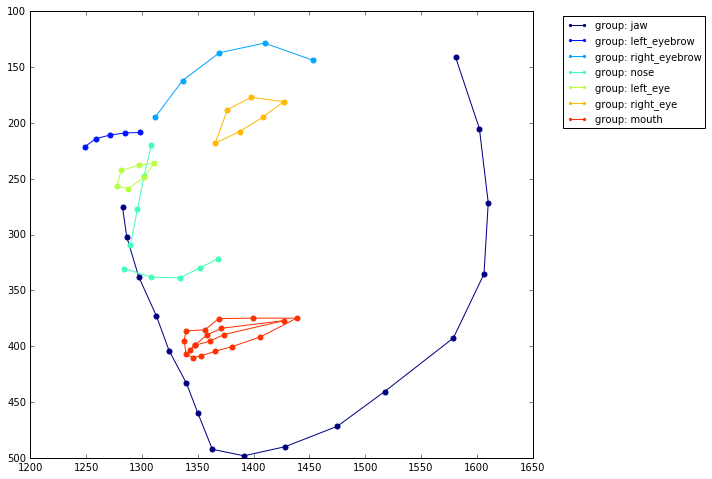

In [15]:
# View a particular group
img.landmarks['face_ibug_68'].view();

Notice that viewing the landmark group itself directly from the manager does not view the object behind it. Also note that the landmarks are incorrectly rotated because the group does not know that its landmarks are actually within the image domain, where the axes are different. To view a particular group we can use the ``group`` kwarg of the ``view_landmarks`` method as follows:

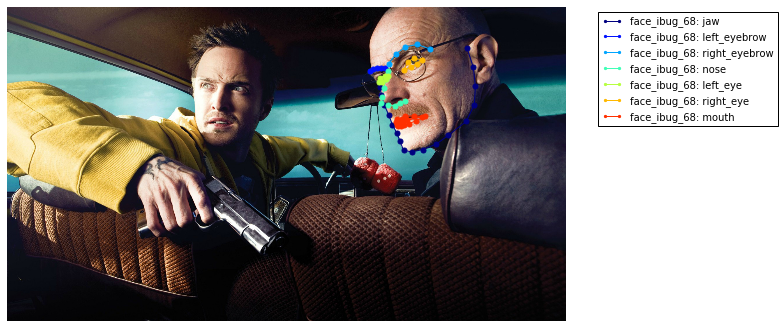

In [16]:
# View a particular group
img.view_landmarks(group='face_ibug_68', render_legend=True);

We can also view a particular semantic label, like the nose

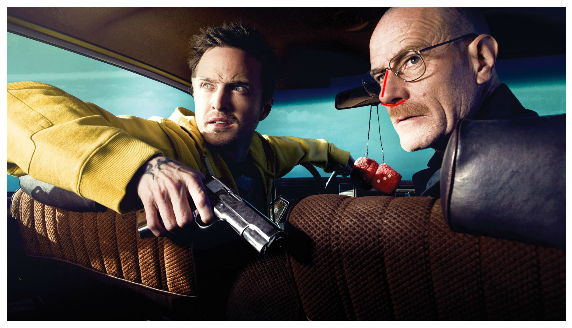

In [17]:
# View a particular group and label
img.view_landmarks(group='face_ibug_68', with_labels='nose', render_markers=False, line_width=2, line_colour='r');

Or visualize multiple labels

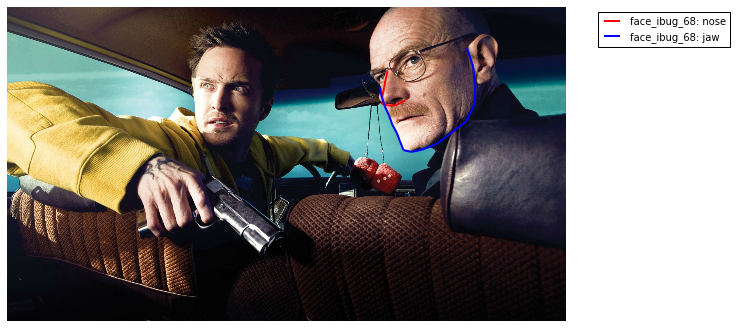

In [18]:
img.view_landmarks(group='face_ibug_68', with_labels=['nose', 'jaw'], 
                   render_markers=False, line_width=2, line_colour=['r', [0, 0, 1]], render_legend=True);

And of course we can do the inverse, create a group **without** a particular set of landmarks

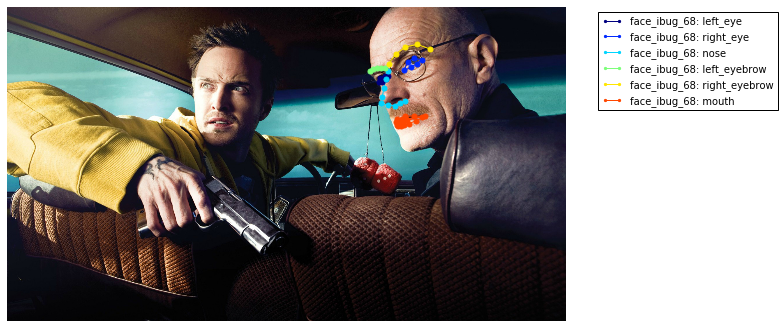

In [19]:
img.view_landmarks(group='face_ibug_68', without_labels=['all', 'jaw'], render_legend=True);

## 4. Removing Labels

As a short aside, you might not want to delete a specific label. Or, you might want to get rid of the imported 'PTS' label and only keep your newly semantically labelled 'ibug_face_68' group. Fortunately, the ``LandmarkManager`` and ``LandmarkGroup`` also act like dictionaries in this regard. Simply ``del`` the keys!

In [20]:
# Add a 'face' label to the 'PTS' group
img.landmarks['PTS']['face'] = range(68)

print('Breaking Bad (PTS) has labels:')
for l in img.landmarks['PTS']:
    print(' - {}'.format(l))
    
# Delete the 'all' label
del img.landmarks['PTS']['all']

print('Breaking Bad (PTS) NOW has labels:')
for l in img.landmarks['PTS']:
    print(' - {}'.format(l))

Breaking Bad (PTS) has labels:
 - all
 - face
Breaking Bad (PTS) NOW has labels:
 - face


In [21]:
# Delete the 'ibug_face_68' group
del img.landmarks['face_ibug_68']

if 'face_ibug_68' not in img.landmarks:
    print("Breaking Bad does not contain the 'face_ibug_68' group")

Breaking Bad does not contain the 'face_ibug_68' group


## 5.  Re-assigning landmarks

If you have a set of landmarks on one image, or even if you just have a ``PointCloud`` that you want to set as landmarks, this is equally simple.

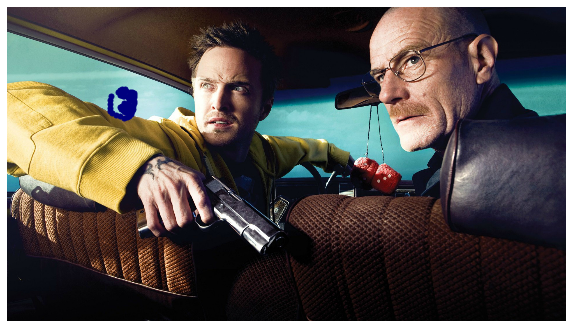

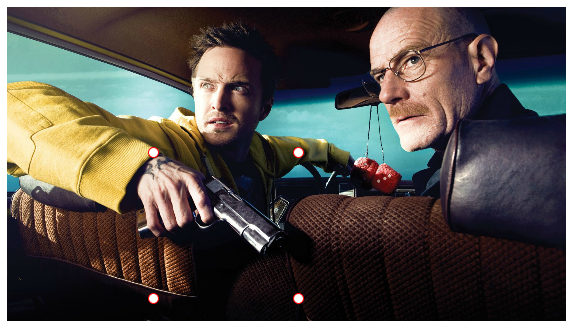

In [22]:
other_img = images[1]

img.landmarks['someone_elses_landmarks'] = other_img.landmarks['PTS']
img.landmarks['a_pointcloud'] = PointCloud(np.array([[500, 500], [500, 1000], [1000, 500], [1000, 1000]]))

img.view_landmarks(group='someone_elses_landmarks');
img.view_landmarks(new_figure=True, group='a_pointcloud', marker_size=10, marker_face_colour='w', marker_edge_colour='r');

## 6. Widget

Landmarks can be very easily visualized using widgets. The image widget has a specific _Landmarks options_ tab that allows to browse through the available `LandmarkGroup`s of an `Image`. Note that the _Viewer options_ includes several rendering options. Note that the widget functionality is provided by the menpowidgets project and should be installed separately using conda (`conda install -c menpo menpowidgets`).

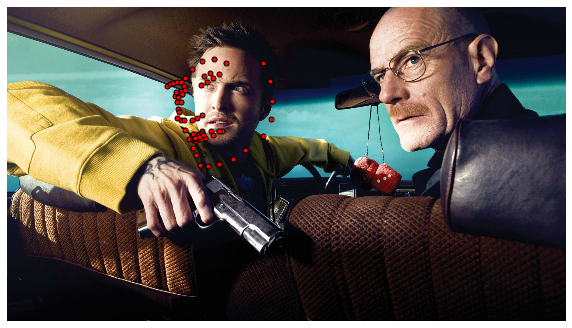

In [23]:
img.view_widget()

A similar `view_widget()` method exists on the `LandmarkManager`...

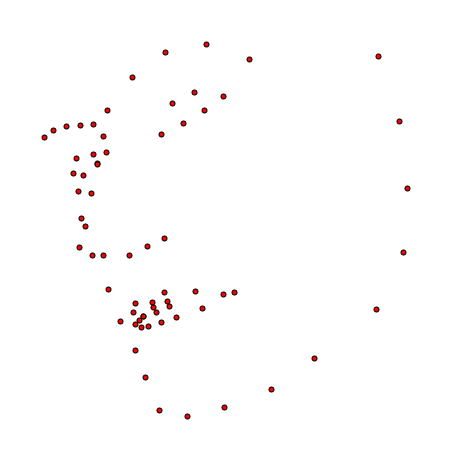

In [24]:
img.landmarks.view_widget()

...and a `LandmarkGroup`.

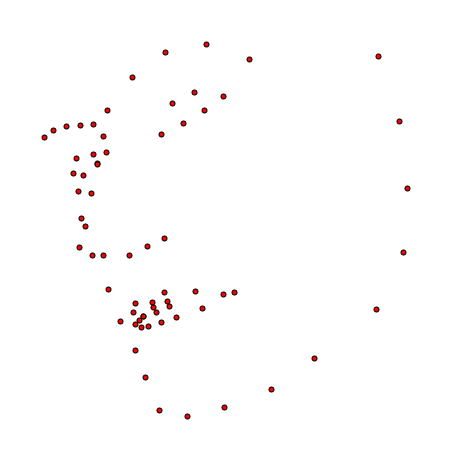

In [25]:
img.landmarks['PTS'].view_widget()

Finally, note that the widgets can visualize a `list` of `LandmarkManager`(s) or `LandmarkGroup`(s) (the same for `list` of `Image`s).

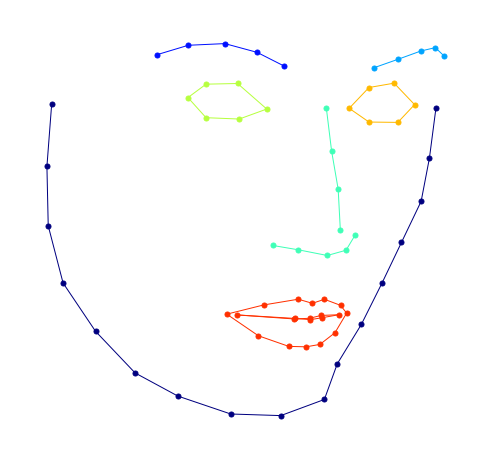

In [26]:
from menpowidgets import visualize_landmarkgroups, visualize_landmarks

# visualize list of LandmarkManager objects
visualize_landmarks([images[2].landmarks, images[0].landmarks, images[1].landmarks])

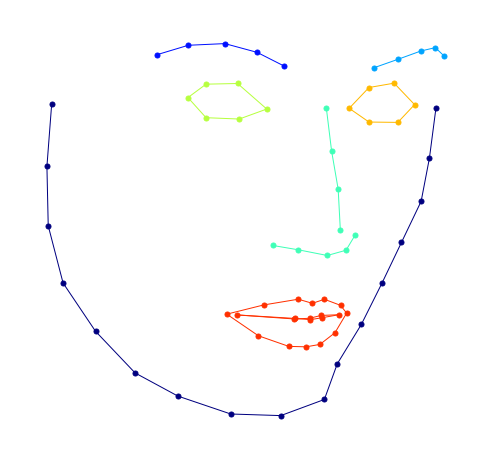

In [27]:
# same can be done for LandmarkGroup objects (uncomment line)
visualize_landmarkgroups([images[2].landmarks['LJSON'], 
                          images[0].landmarks['a_pointcloud'], 
                          images[1].landmarks['PTS']])